In [139]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from iminuit import Minuit
from iminuit.cost import LeastSquares

def configure_plotting():
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = 'tight'
    hep.style.use(hep.style.CMS)

In [140]:
with open('../../genIII_data/JLab/Beam/Beam1_0-Cal.pkl', 'rb') as file:
    # Load the data from the pickle file
    beam_data = pickle.load(file)

with open('../../genIII_data/Sim/Positrons.pkl', 'rb') as file:
    # Load the data from the pickle file
    sim_data = pickle.load(file)
    
e_cut = 0.3

In [141]:
def gauss(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2. * sigma ** 2))

def layer_energy_sums(data, target_layer):
    positions = np.array(data['positions'])  # shape: (num_channels, 5)
    events = data['events']        # shape: (num_events,), each item: (num_channels,)

    layer_mask = positions[:, 3] == target_layer  # index 3 is 'layer'

    # For each event, apply the layer mask and threshold
    return np.array([
        event[layer_mask][event[layer_mask] > e_cut].sum()
        for event in events
    ])

def channel_energy_values(data, target_layer, target_channel):
    positions = np.array(data['positions'])  # shape: (num_channels, 5)
    events = data['events']        # shape: (num_events,), each event is (num_channels,)

    # Extract columns: index 3 is layer, index 4 is channel number
    layer_mask = positions[:, 3] == target_layer
    ch_mask = positions[:, 4] == target_channel

    combined_mask = layer_mask & ch_mask

    if not np.any(combined_mask):
        raise ValueError(f"No channel found for layer {target_layer} and channel {target_channel}")

    idx = np.flatnonzero(combined_mask)[0]  # Should only be one

    return np.array([event[idx] for event in events])

def plot_layer_histograms(beam_data, sim_data, layer_number, bins=40):
    configure_plotting()
    rows, cols = 5, 5
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.flatten()
    
    num_beam_events = len(beam_data["events"])
    num_sim_events = len(sim_data["events"])

    for i in range(25):
        ch = 24 - i  # Invert channel order so 0 is bottom right, 24 is top left
        ax = axes[i]
        try:
            # Beam data
            beam_energies = channel_energy_values(beam_data, layer_number, ch)
            beam_counts, beam_bin_edges = np.histogram(beam_energies, bins=bins, range=[0, 40])
            beam_bin_centers = (beam_bin_edges[:-1] + beam_bin_edges[1:]) / 2
            beam_errors = np.sqrt(beam_counts)
            ax.errorbar(beam_bin_centers, beam_counts / num_beam_events,
                        yerr=beam_errors / num_beam_events, fmt='o', markersize=2,
                        color='blue', label='Beam')

            # Sim data
            sim_energies = channel_energy_values(sim_data, layer_number, ch)
            sim_counts, sim_bin_edges = np.histogram(sim_energies, bins=bins, range=[0, 40])
            sim_bin_centers = (sim_bin_edges[:-1] + sim_bin_edges[1:]) / 2
            sim_errors = np.sqrt(sim_counts)
            ax.errorbar(sim_bin_centers, sim_counts / num_sim_events,
                        yerr=sim_errors / num_sim_events, fmt='o', markersize=2,
                        color='orange', label='Sim')

            ax.set_ylim(0.0001, 1)
            ax.set_yscale('log')
            ax.legend(fontsize=8)
        except ValueError:
            ax.set_visible(False)

    for ax in axes[-cols:]:
        ax.set_xlabel("Energy [MIP]", fontsize=10)
    for ax in axes[::cols]:
        ax.set_ylabel("Counts (Norm)", fontsize=10)
        
    for i, ax in enumerate(axes):
        if i % cols != 0:
            ax.set_yticklabels([])
        if i < (cols * (rows - 1)):
            ax.set_xticklabels([])

    plt.suptitle(f"Layer {layer_number}", fontsize=18, y=1.02)
    plt.tight_layout(pad=0.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

    
def plot_all_layers(beam_data, sim_data, bins=40):
    configure_plotting()
    num_layers = 15
    rows, cols = 3, 5

    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()

    num_beam_events = len(beam_data["events"])
    num_sim_events = len(sim_data["events"])

    for layer_number in range(num_layers):
        ax = axes[layer_number]
        
        try:
            # Beam data
            beam_energies = layer_energy_sums(beam_data, layer_number)
            beam_counts, beam_bin_edges = np.histogram(beam_energies, bins=bins, range=[0, 100])
            beam_bin_centers = (beam_bin_edges[:-1] + beam_bin_edges[1:]) / 2
            beam_errors = np.sqrt(beam_counts)
            ax.errorbar(beam_bin_centers, beam_counts / num_beam_events,
                        yerr=beam_errors / num_beam_events, fmt='o', markersize=2,
                        color='blue', label='Beam')

            # Simulation data
            sim_energies = layer_energy_sums(sim_data, layer_number)
            sim_counts, sim_bin_edges = np.histogram(sim_energies, bins=bins, range=[0, 100])
            sim_bin_centers = (sim_bin_edges[:-1] + sim_bin_edges[1:]) / 2
            sim_errors = np.sqrt(sim_counts)
            ax.errorbar(sim_bin_centers, sim_counts / num_sim_events,
                        yerr=sim_errors / num_sim_events, fmt='o', markersize=2,
                        color='orange', label='Sim')
            
            ax.set_ylim(0.0001, 1)
            ax.set_yscale('log')
            ax.set_title(f'Layer {layer_number}', fontsize=10)
            ax.legend(fontsize=8)

        except ValueError:
            ax.set_visible(False)

    for ax in axes[-cols:]:
        ax.set_xlabel("Energy [MIP]", fontsize=10)
    for ax in axes[::cols]:
        ax.set_ylabel("Counts (Norm)", fontsize=10)
        
    for i, ax in enumerate(axes):
        if i % cols != 0:
            ax.set_yticklabels([])
        if i < (cols * (rows - 1)):
            ax.set_xticklabels([])

    plt.suptitle(f"Energy Distributions for Layers 0-14", fontsize=18, y=1.02)
    plt.tight_layout(pad=0.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

    
def total_event_energies(data):
    events = data['events']  # shape: (num_events,), each item: (num_channels,)

    return np.array([
        event[event > e_cut].sum()
        for event in events
    ])




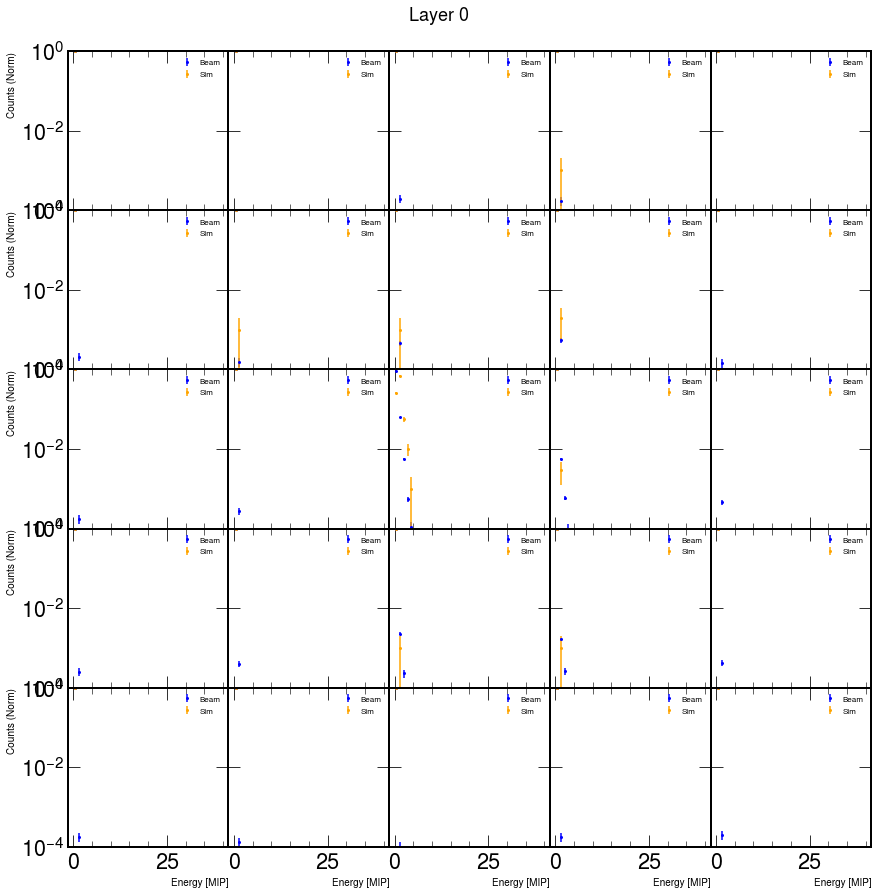

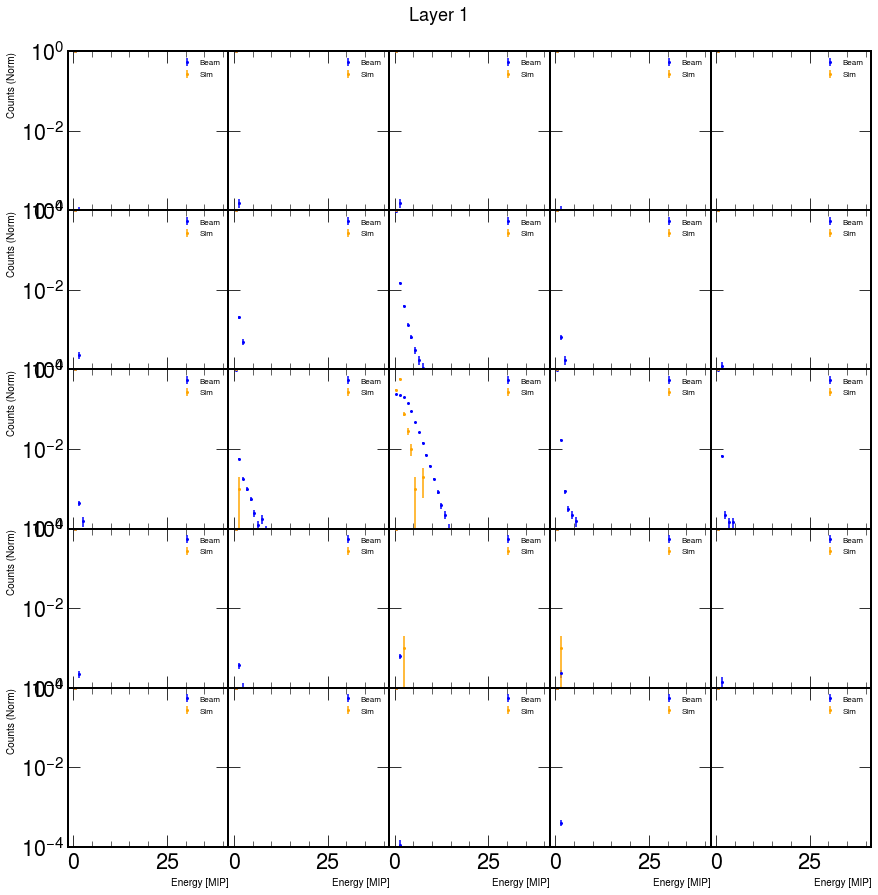

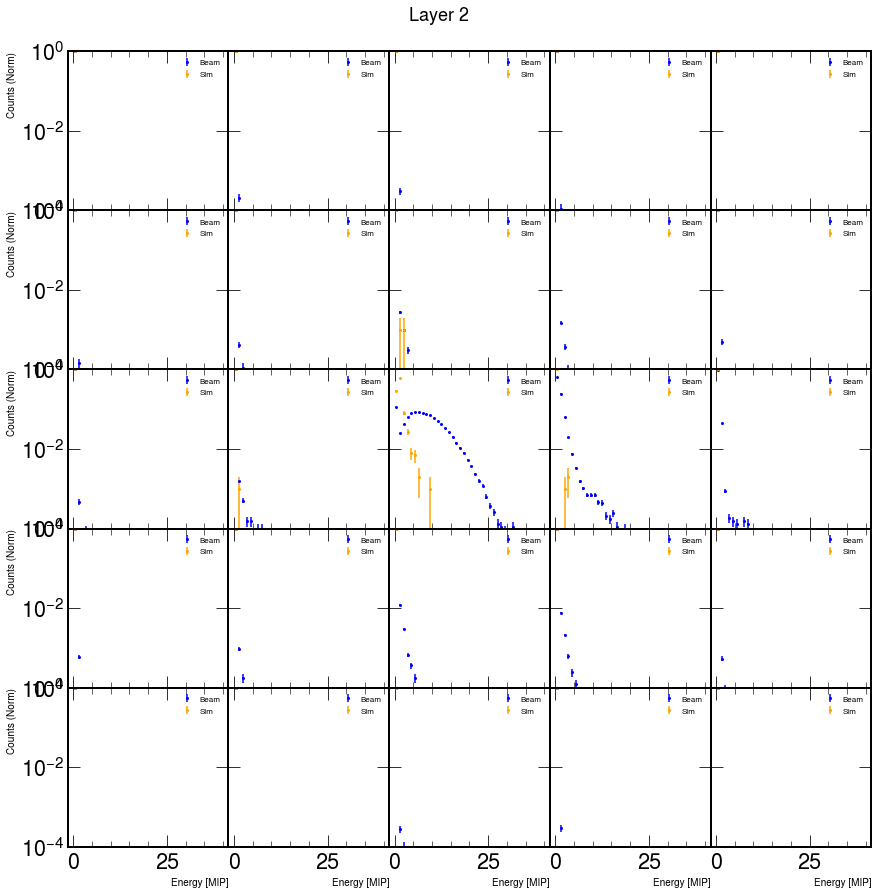

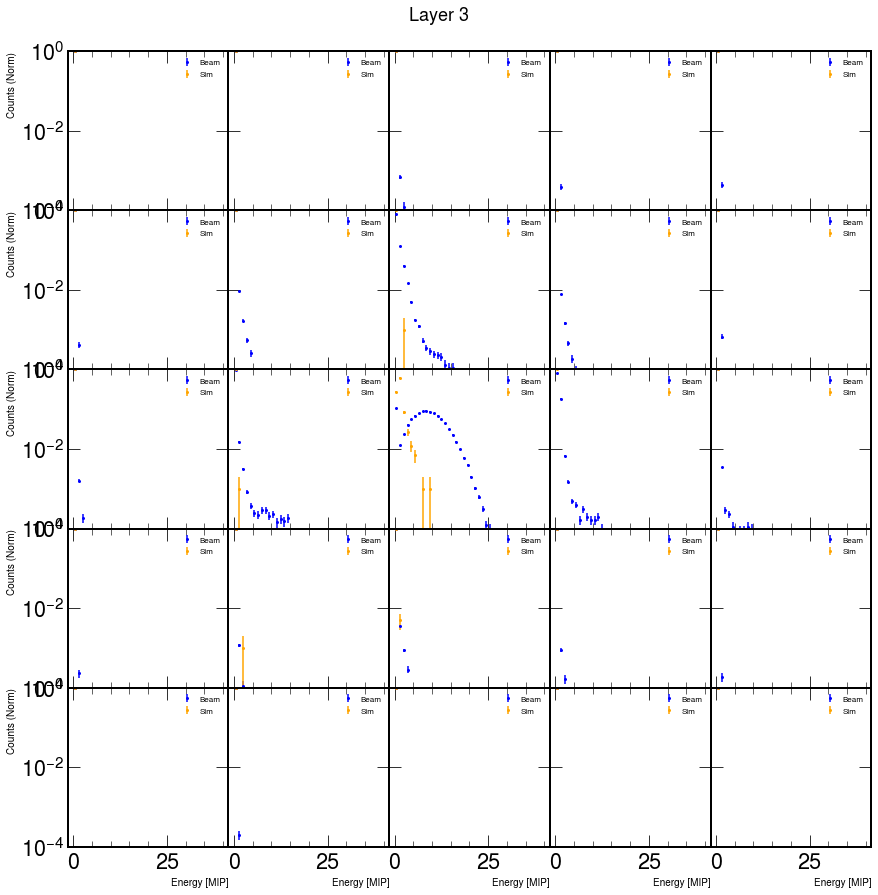

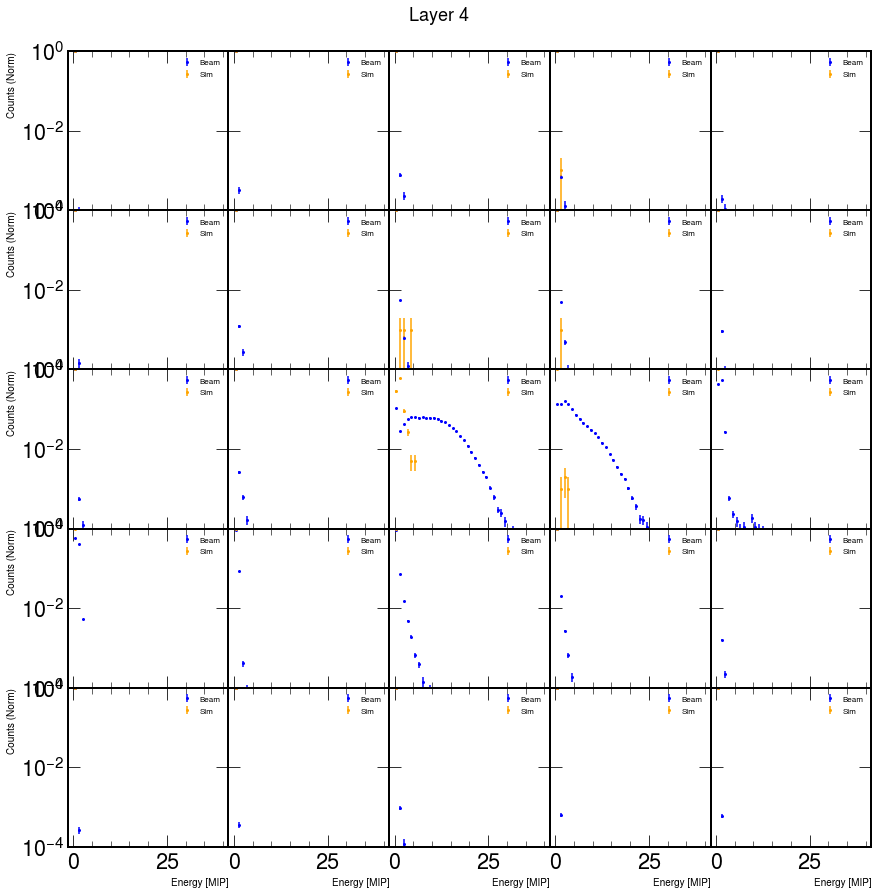

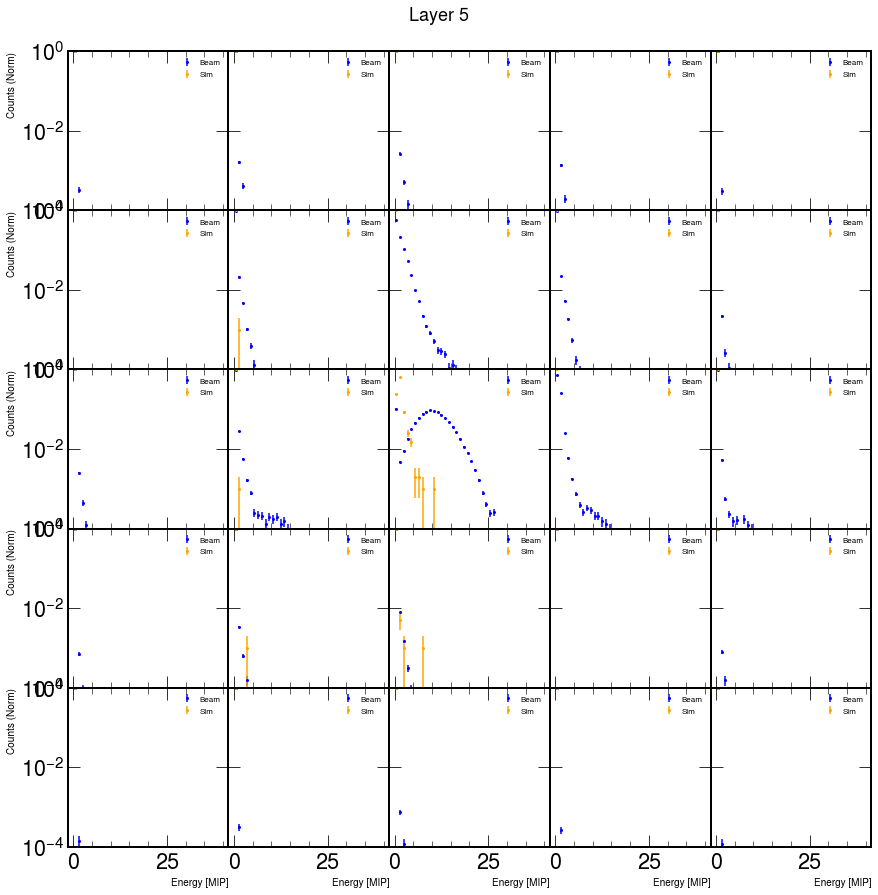

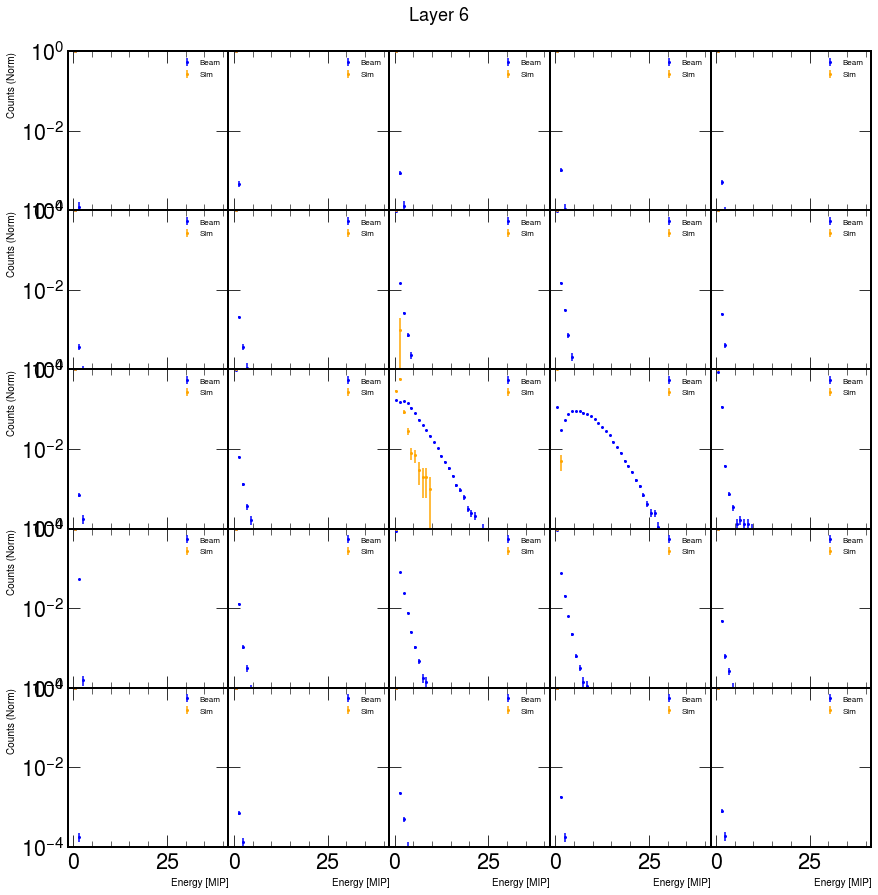

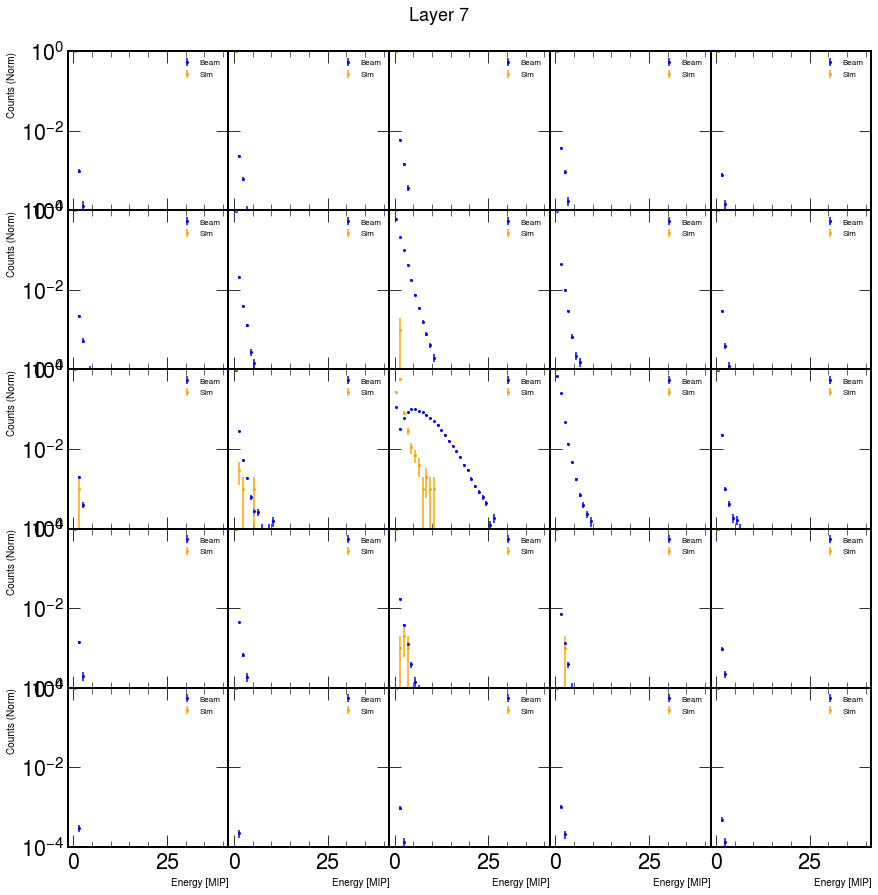

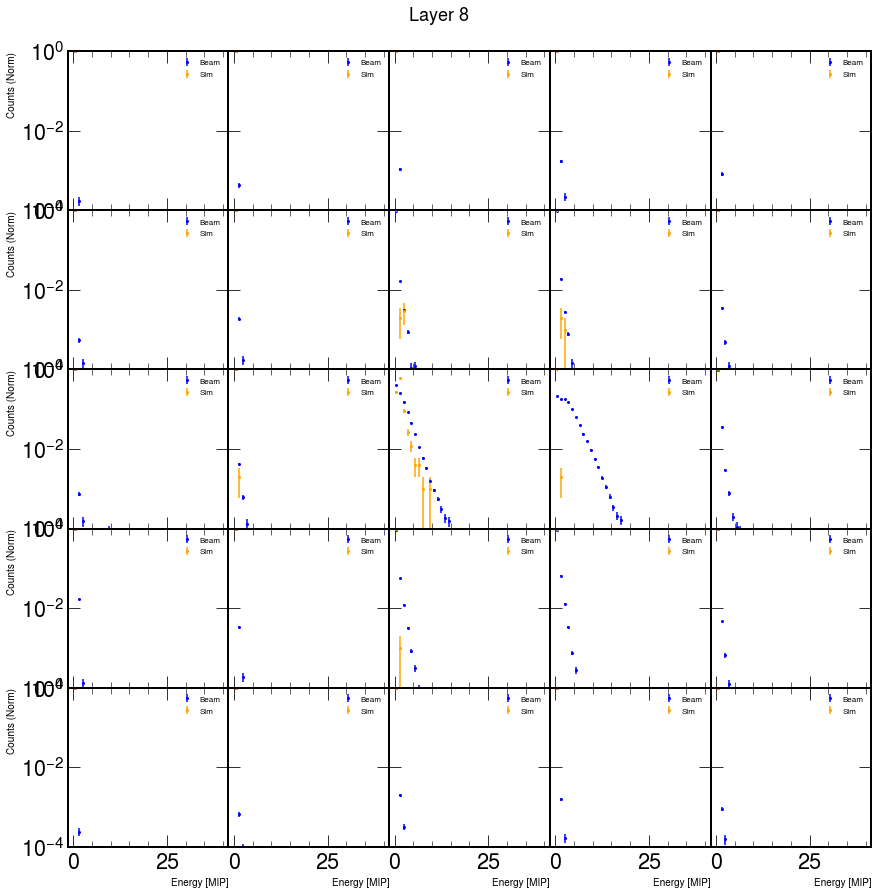

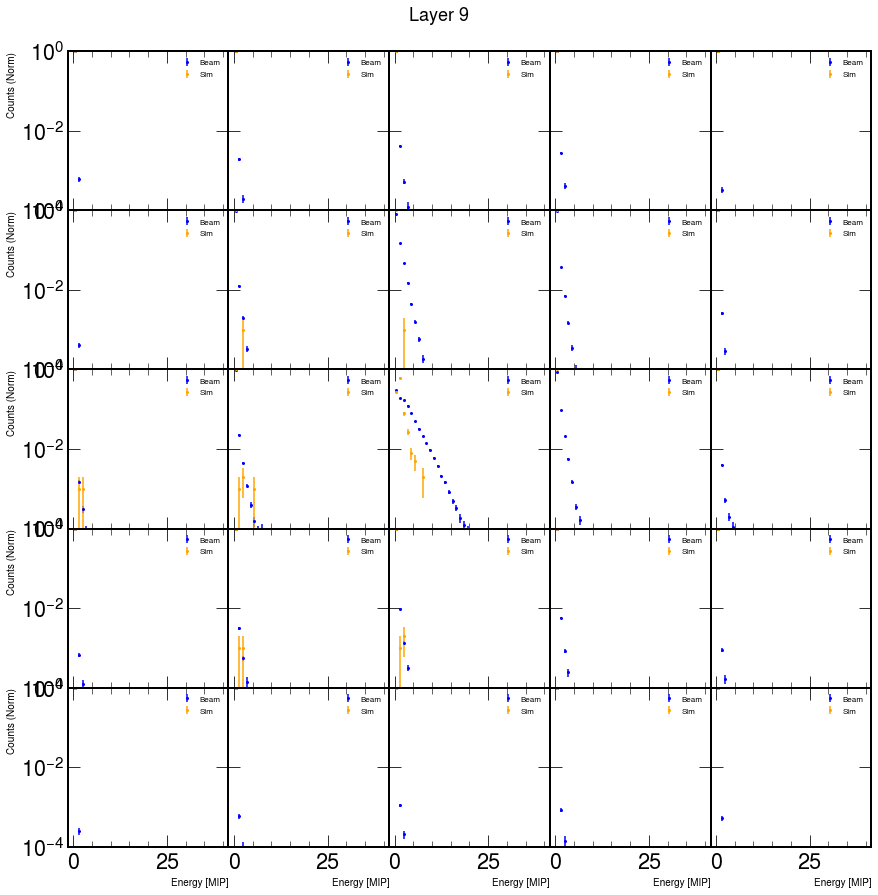

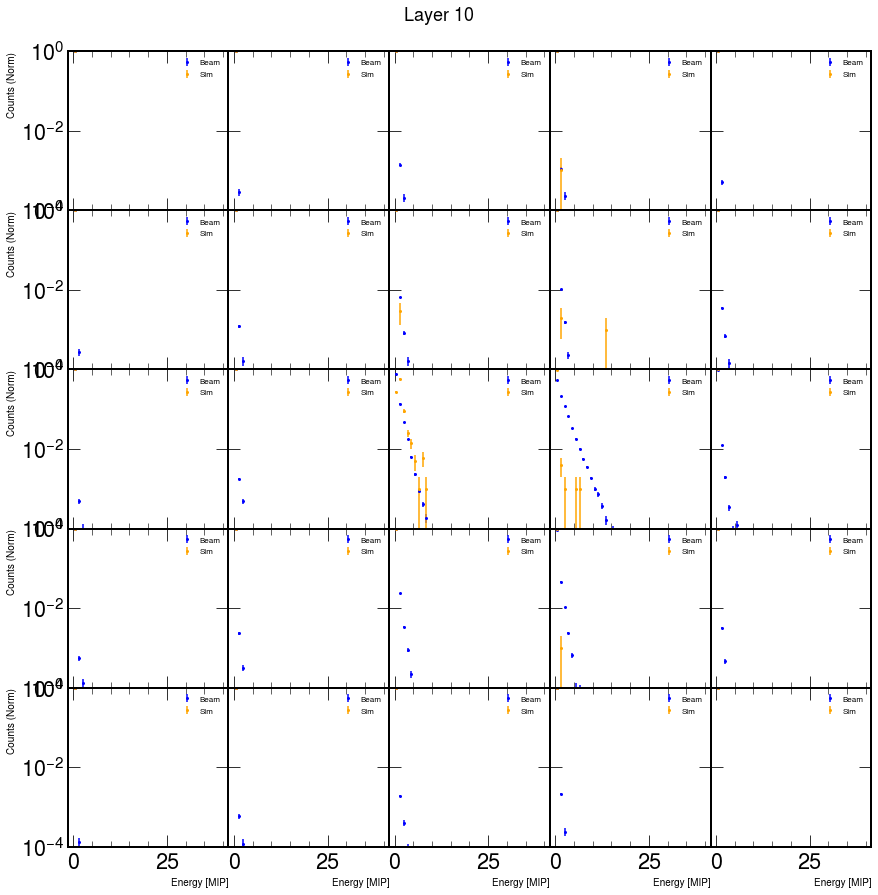

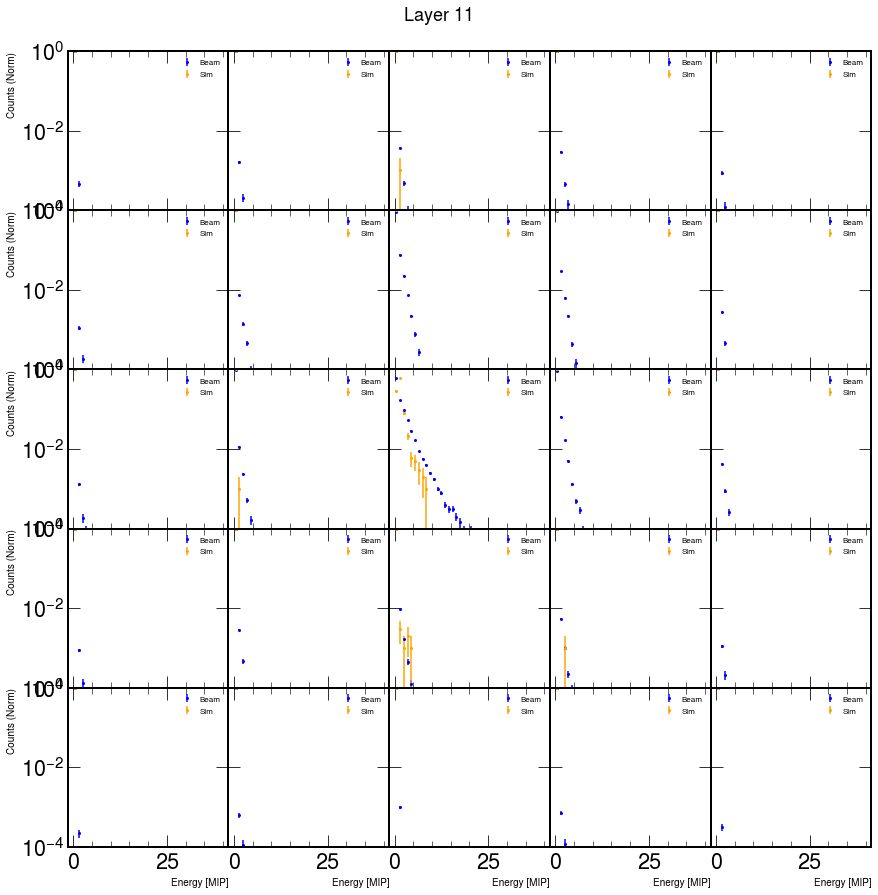

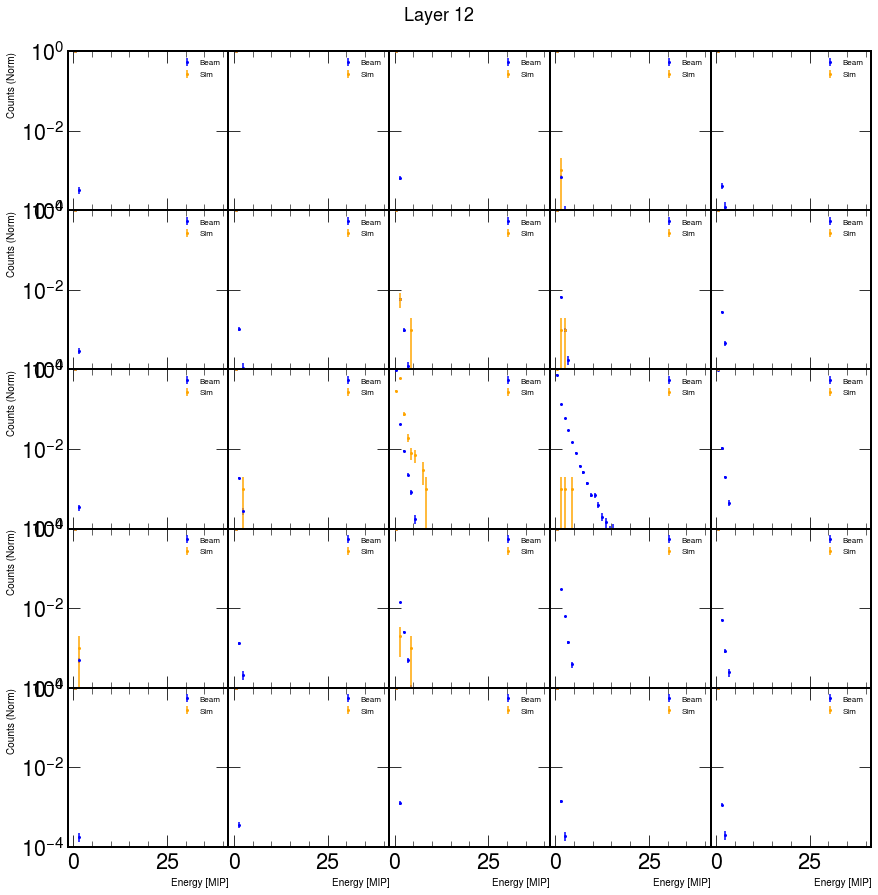

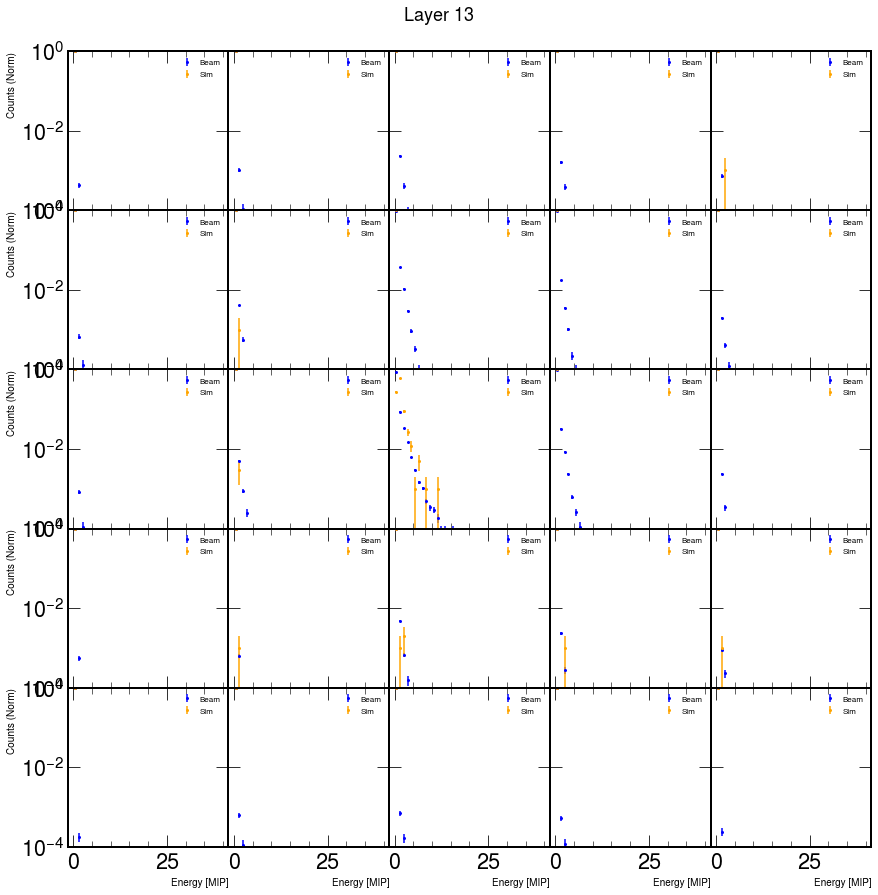

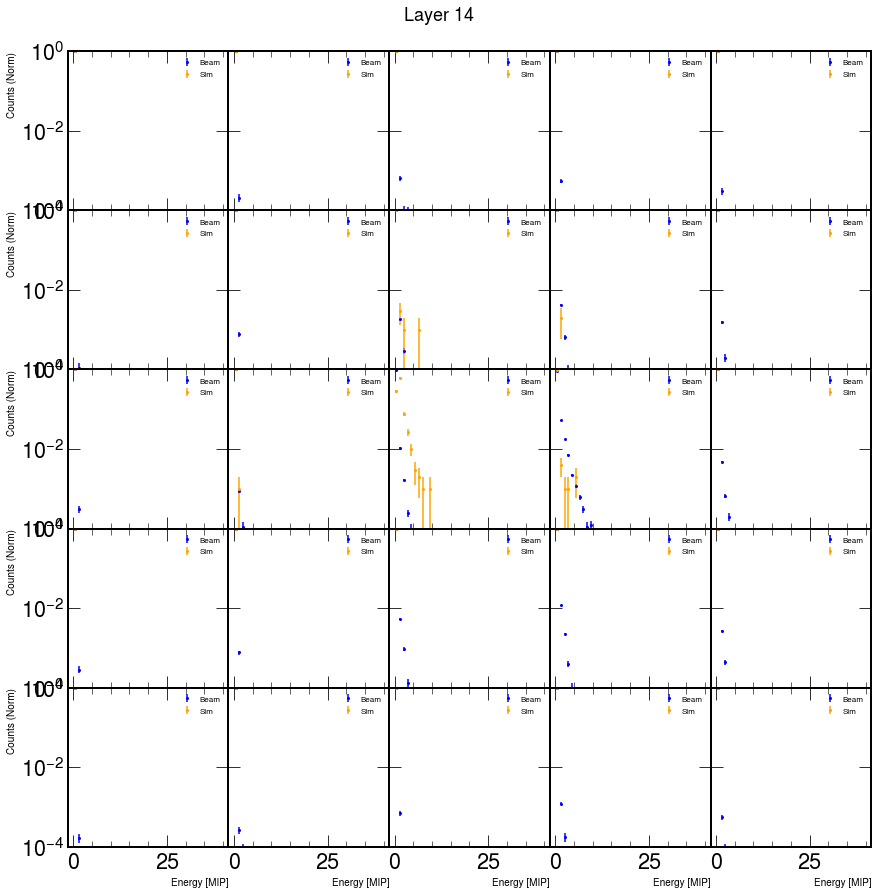

In [138]:
for i in range(15):
    plot_layer_histograms(beam_data, sim_data, i, bins=40)

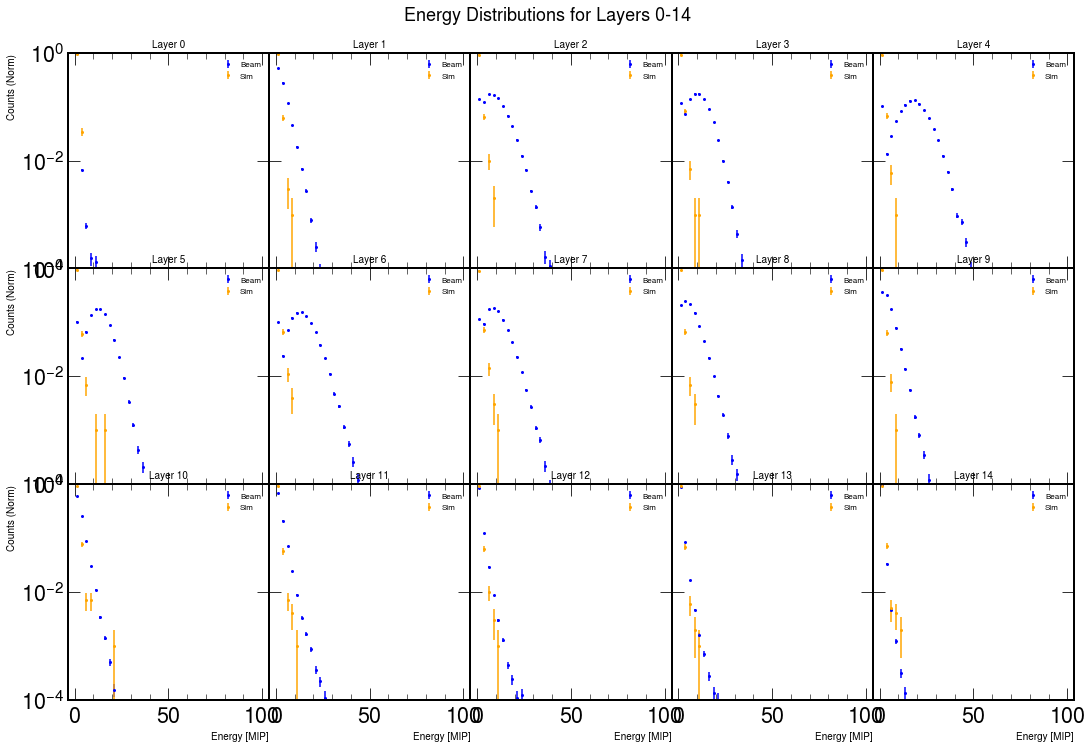

In [142]:
plot_all_layers(beam_data, sim_data)

In [128]:
beam_energies = total_event_energies(beam_data)
sim_energies = total_event_energies(sim_data)

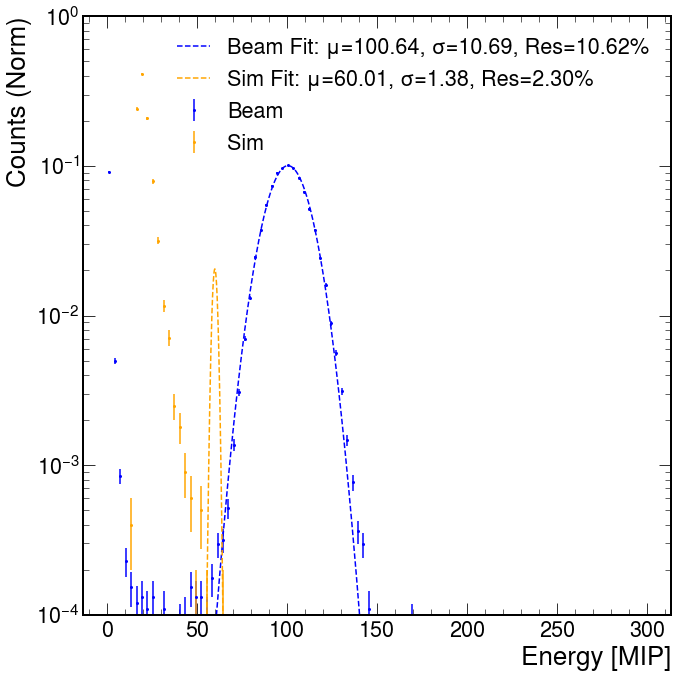

In [129]:
def fit_gaussian_histogram(energies, bin_centers, counts, errors, total_events, color, label_prefix):
    # Only use bins with data
    mask = counts > 0
    x = bin_centers[mask]
    y = counts[mask] / total_events
    yerr = errors[mask] / total_events

    # Initial guesses
    init = [max(y), np.mean(energies[energies > 50]), np.std(energies[energies > 50])]
    least_squares = LeastSquares(x, y, yerr, gauss)
    m = Minuit(least_squares, A=init[0], mu=init[1], sigma=init[2])
    m.limits["sigma"] = (0, None)
    m.migrad()

    # Fit values
    A, mu, sigma = m.values["A"], m.values["mu"], m.values["sigma"]
    fit_x = np.linspace(bin_centers[0], bin_centers[-1], 1500)
    fit_y = gauss(fit_x, A, mu, sigma)
    resolution = (sigma / mu) * 100

    plt.plot(fit_x, fit_y, color=color, linestyle='--',
             label=f"{label_prefix} Fit: μ={mu:.2f}, σ={sigma:.2f}, Res={resolution:.2f}%")
    
    return m  # Optionally return fit result for further use

def plot_energy_histogram(beam_energies, sim_energies, bins=100, x_range=(0, 100),
                          xlabel="Energy [MIP]", ylabel="Counts (Norm)"):
    configure_plotting()

    # Histogram beam
    num_beam = len(beam_energies)
    beam_counts, bin_edges = np.histogram(beam_energies, bins=bins, range=x_range)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    beam_errors = np.sqrt(beam_counts)

    # Histogram sim
    num_sim = len(sim_energies)
    sim_counts, _ = np.histogram(sim_energies, bins=bin_edges)
    sim_errors = np.sqrt(sim_counts)

    # Plot data
    plt.errorbar(bin_centers, beam_counts/num_beam, yerr=beam_errors/num_beam,
                 fmt='o', markersize=2, color='blue', label='Beam')
    plt.errorbar(bin_centers, sim_counts/num_sim, yerr=sim_errors/num_sim,
                 fmt='o', markersize=2, color='orange', label='Sim')

    # Fit and plot
    fit_gaussian_histogram(beam_energies, bin_centers, beam_counts, beam_errors, num_beam, 'blue', 'Beam')
    fit_gaussian_histogram(sim_energies, bin_centers, sim_counts, sim_errors, num_sim, 'orange', 'Sim')

    # Plot formatting
    plt.yscale('log')
    plt.ylim(0.0001, 1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_energy_histogram(beam_energies, sim_energies, bins=100, x_range=(0, 300))

In [130]:
def event_energy_and_center_of_gravity(beam_data):
    positions = beam_data['positions']  # shape: (num_channels, 5) with x, y, z, layer, ch
    events = beam_data['events']        # list of (num_channels,) arrays

    results = []

    for event in events:
        event = np.asarray(event)
        mask = event > e_cut

        if np.count_nonzero(mask) == 0:
            results.append((0.0, np.nan, np.nan, np.nan))
            continue

        energies = event[mask]
        xs, ys, zs = positions[mask, 0], positions[mask, 1], positions[mask, 2]

        energy_sum = energies.sum()
        cog_x = np.average(xs, weights=energies)
        cog_y = np.average(ys, weights=energies)
        cog_z = np.average(zs, weights=energies)

        results.append((energy_sum, cog_x, cog_y, cog_z))

    return np.array(results, dtype=[('energy_sum', 'f4'), ('x', 'f4'), ('y', 'f4'), ('z', 'f4')])


In [131]:
def plot_cog(cog_beam, cog_sim, bins=50, ranges=None):
    configure_plotting()
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    labels = ['X', 'Y', 'Z']
    keys = ['x', 'y', 'z']
    colors = ['tab:blue', 'tab:orange']

    for ax, key, label, rng in zip(axes, keys, labels, ranges if ranges else [None]*3):
        for cog_data, name, color in zip([cog_beam, cog_sim], ['Beam', 'Sim'], colors):
            valid = ~np.isnan(cog_data[key])
            vals = cog_data[key][valid]
            num_evts = len(vals)

            counts, bin_edges = np.histogram(vals, bins=bins, range=rng)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            errors = np.sqrt(counts)

            ax.errorbar(bin_centers, counts/num_evts, yerr=errors/num_evts, fmt='o',
                        markersize=3, label=name, color=color)

        ax.set_title(f'Center of Gravity - {label}')
        ax.set_xlabel(f'{label} [mm]')
        ax.set_ylabel('Counts (Norm)')
        ax.set_yscale('log')
        ax.set_ylim(0.001, 1)
        ax.legend()

    plt.tight_layout()
    plt.show()


In [132]:
cog_beam = event_energy_and_center_of_gravity(beam_data)
cog_sim = event_energy_and_center_of_gravity(sim_data)

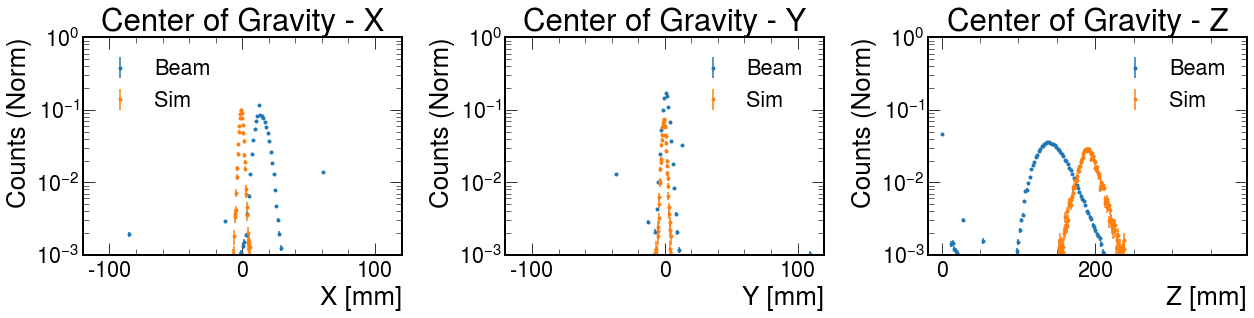

In [133]:
plot_cog(cog_beam, cog_sim, bins=200)

In [51]:
high_indexes = []
for i in range(len(energies)):
    if(energies[i] > 50):
        high_indexes.append(i)

In [52]:
def plot_event_3d(beam_data, evtnum):
    positions = beam_data['positions']  # shape: (num_channels, 5)
    events = beam_data['events']        # list of arrays, each shape: (num_channels,)
    
    energies = events[evtnum]
    above_thresh = energies > e_cut
    
    # Extract x, y, z positions for valid hits
    xs = positions[above_thresh, 0]
    ys = positions[above_thresh, 1]
    zs = positions[above_thresh, 2]
    hits = energies[above_thresh]
    
    # Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(xs, zs, ys, c=hits, cmap='viridis', s=50)

    # Add colorbar
    cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
    cbar = plt.colorbar(sc, cax=cbar_ax)
    cbar.set_label("Energy [MIP]")

    ax.set_xlabel("X [mm]", labelpad=15)
    ax.set_ylabel("Z [mm]", labelpad=15)
    ax.set_zlabel("Y [mm]", labelpad=15)
    ax.set_title(f"Event {evtnum}")
    ax.set_ylim(0,400)
    ax.set_xlim(-100,100)
    ax.set_zlim(-100,100)
    plt.subplots_adjust(right=0.85)
    plt.show()


plt.show()

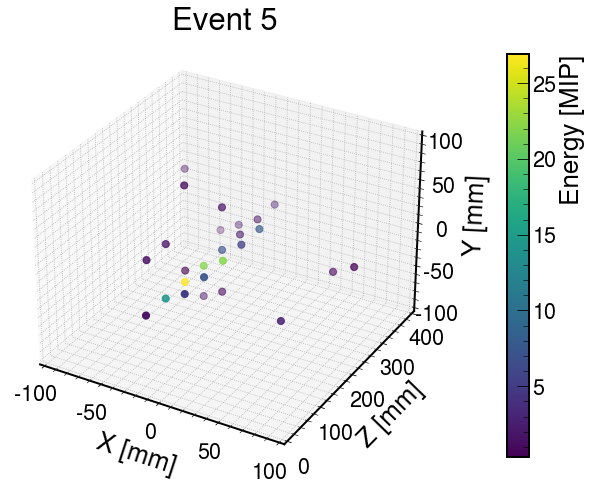

In [56]:
plot_event_3d(beam_data, high_indexes[5])

In [54]:
def plot_event_projections(beam_data, evtnum, threshold=0.3):
    positions = beam_data['positions']  # shape: (num_channels, 5)
    event = beam_data['events'][evtnum]  # shape: (num_channels,)

    # Filter hits above threshold
    mask = event > threshold
    energies = event[mask]
    pos_filtered = positions[mask]

    xs = pos_filtered[:, 0]  # x [mm]
    ys = pos_filtered[:, 1]  # y [mm]
    zs = pos_filtered[:, 2]  # z [mm]

    def plot_energy_projection(x, y, energy, xlabel, ylabel, title):
        df = pd.DataFrame({
            'x': x,
            'y': y,
            'energy': energy
        })

        grouped = df.groupby(['x', 'y'], as_index=False).sum()
        configure_plotting()
        plt.figure(figsize=(8, 6))
        sc = plt.scatter(grouped['x'], grouped['y'], c=grouped['energy'],
                         cmap='viridis', s=80)
        plt.colorbar(sc, label='Energy [MIP]')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

    plot_energy_projection(xs, ys, energies, 'X [mm]', 'Y [mm]', f'XY Projection - Event {evtnum}')
    plot_energy_projection(xs, zs, energies, 'X [mm]', 'Z [mm]', f'XZ Projection - Event {evtnum}')
    plot_energy_projection(ys, zs, energies, 'Y [mm]', 'Z [mm]', f'YZ Projection - Event {evtnum}')


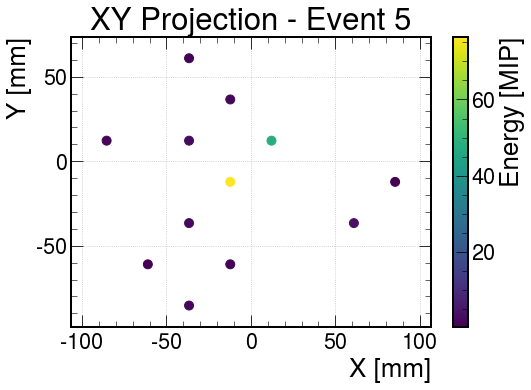

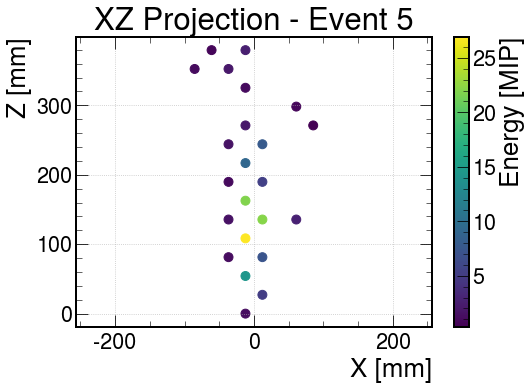

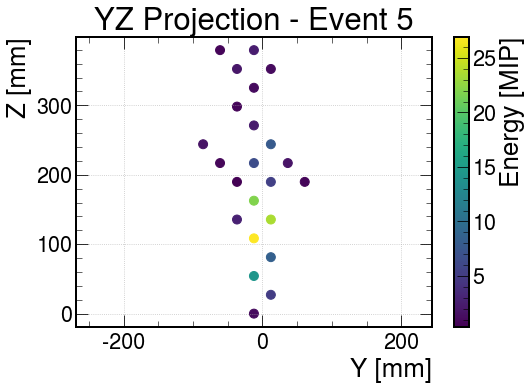

In [55]:
plot_event_projections(beam_data, evtnum=high_indexes[5])